In [1]:
import tensorflow as tf
import math
import tensorflow.keras.backend as backend
# from keras.keras.initializers.initializers_v2 import HaeNormal
# import keras.keras as keras
# tf.__version__
# keras
_PARTITION_SHAPE = 'partition_shape'
_PARTITION_OFFSET = 'partition_offset'
_ALLOWED_INITIALIZER_KWARGS = [_PARTITION_SHAPE, _PARTITION_OFFSET]


class HaeNormal(tf.keras.initializers.Initializer):
  def __init__(self,
               scale=1.0,
               mode='fan_in',
               distribution='truncated_normal',
               seed=None,
               version = 0
               ):
    if scale <= 0.:
      raise ValueError('`scale` must be positive float. '
                       f'Received: scale={scale}.')
    allowed_modes = {'fan_in', 'fan_out', 'fan_avg'}
    if mode not in allowed_modes:
      raise ValueError(f'Invalid `mode` argument: {mode}. '
                       f'Please use one of the {allowed_modes}.')
    distribution = distribution.lower()
    # Compatibility with keras-team/keras.
    if distribution == 'normal':
      distribution = 'truncated_normal'
    allowed_distributions = {
        'uniform', 'truncated_normal', 'untruncated_normal'
    }
    if distribution not in allowed_distributions:
      raise ValueError(f'Invalid `distribution` argument: {distribution}.'
                       f'Allowed distributions: {allowed_distributions}.')
    self.scale = scale
    self.mode = mode
    self.distribution = distribution
    self.seed = seed
    self._random_generator = backend
    self.version = version

  def __call__(self, shape, dtype=None, **kwargs):
    """Returns a tensor object initialized as specified by the initializer.

    Args:
      shape: Shape of the tensor.
      dtype: Optional dtype of the tensor. Only floating point types are
        supported. If not specified, `tf.keras.backend.floatx()` is used, which
        default to `float32` unless you configured it otherwise (via
        `tf.keras.backend.set_floatx(float_dtype)`)
      **kwargs: Additional keyword arguments.
    """
    _validate_kwargs(self.__class__.__name__, kwargs)
    dtype = _assert_float_dtype(_get_dtype(dtype))
    scale = self.scale
    fan_in, fan_out = _compute_fans(shape)
    if _PARTITION_SHAPE in kwargs:
      shape = kwargs[_PARTITION_SHAPE]
    if self.mode == 'fan_in':
      scale /= max(1., fan_in)
    elif self.mode == 'fan_out':
      scale /= max(1., fan_out)
    else:
      scale /= max(1., (fan_in + fan_out) / 2.)
    if self.distribution == 'truncated_normal':
      # constant from scipy.stats.truncnorm.std(a=-2, b=2, loc=0., scale=1.)
      stddev = math.sqrt(scale) / .87962566103423978
      if self.version == 0:
        return self._random_generator.truncated_normal(shape, 0.0, stddev, dtype)
      elif self.version == 1:
        # return np.random.randn(fan_in,fan_out)/np.sqrt(fan_in) + 1/np.sqrt(fan_in)/np.sqrt(fan_in)
        return self._random_generator.truncated_normal(shape, 1/(stddev*stddev), stddev, dtype)
      else:
        return np.random.randn(fan_in,fan_out)/np.sqrt(fan_in) + 0.5/fan_in
    elif self.distribution == 'untruncated_normal':
      stddev = math.sqrt(scale)
      return self._random_generator.random_normal(shape, 0.0, stddev, dtype)
    else:
      limit = math.sqrt(3.0 * scale)
      return self._random_generator.random_uniform(shape, -limit, limit, dtype)

  def get_config(self):
    return {
        'scale': self.scale,
        'mode': self.mode,
        'distribution': self.distribution,
        'seed': self.seed
    }



def _get_dtype(dtype):
  if dtype is None:
    dtype = backend.floatx()
  return tf.as_dtype(dtype)


def _assert_float_dtype(dtype):
  """Validate and return floating point type based on `dtype`.

  `dtype` must be a floating point type.

  Args:
    dtype: The data type to validate.

  Returns:
    Validated type.

  Raises:
    ValueError: if `dtype` is not a floating point type.
  """
  dtype = tf.as_dtype(dtype)
  if not dtype.is_floating:
    raise ValueError(f'Expected floating point type, got {dtype}.')
  return dtype


def _compute_fans(shape):
  """Computes the number of input and output units for a weight shape.

  Args:
    shape: Integer shape tuple or TF tensor shape.

  Returns:
    A tuple of integer scalars (fan_in, fan_out).
  """
  if len(shape) < 1:  # Just to avoid errors for constants.
    fan_in = fan_out = 1
  elif len(shape) == 1:
    fan_in = fan_out = shape[0]
  elif len(shape) == 2:
    fan_in = shape[0]
    fan_out = shape[1]
  else:
    # Assuming convolution kernels (2D, 3D, or more).
    # kernel shape: (..., input_depth, depth)
    receptive_field_size = 1
    for dim in shape[:-2]:
      receptive_field_size *= dim
    fan_in = shape[-2] * receptive_field_size
    fan_out = shape[-1] * receptive_field_size
  return int(fan_in), int(fan_out)


def _validate_kwargs(cls_name, kwargs, support_partition=True):
  for kwarg in kwargs:
    if kwarg not in _ALLOWED_INITIALIZER_KWARGS:
      raise TypeError(f'Unknown keyword arguments: {kwarg}. Allowed keyword '
                      f'arguments: {_ALLOWED_INITIALIZER_KWARGS}.')
    elif not support_partition:
      raise ValueError(f'{cls_name} initializer doesn\'t support '
                       'partition-related arguments.')

AlreadyExistsError: Another metric with the same name already exists.

In [157]:
# inint = HaeNormal(version=1)
1/np.sqrt(128)

0.08838834764831843

In [49]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [50]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [219]:
train_images = train_images / 255.0

test_images = test_images / 255.0
train_images = train_images.reshape(-1,28,28,1)
test_images= test_images.reshape(-1,28,28,1)
train_images.shape


(60000, 28, 28, 1)

In [213]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
def conv_block_50(num,init_size,x,name,plain = False,First = False,inintial = 'glorot_uniform'):
    for i in range(0,num):
        # print(i)
        if First == True and i == 0:
            short = x
            x = Conv2D(filters= init_size,kernel_initializer=inintial,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_1')(x)
        elif i == 0:
            short = x
            x = Conv2D(filters= init_size, kernel_initializer=inintial,strides=2,padding='same',
                        kernel_size=(1,1),name=f'stage{name}_{i+1}_1')(x)
            # short = Conv2D(filters= init_size,strides=2,padding='same',
            #             kernel_size=(3,3),name=f'stage{name}_{i+1}_1_short')(short)
        else:
            x = Conv2D(filters= init_size,
                        kernel_size=(1,1),kernel_initializer=inintial ,padding='same',name=f'stage{name}_{i+1}_1')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)
        x = Conv2D(filters= init_size, kernel_initializer=inintial,
                    kernel_size=(3,3),padding='same',name=f'stage{name}_{i+1}_2')(x)
        x = BatchNormalization()(x)
        x = Activation(activation='relu')(x)           
        x = Conv2D(filters= init_size*4, kernel_initializer=inintial, 
                    kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_3')(x)
        x = BatchNormalization()(x)
        if First == True and i == 0:
            short = Conv2D(filters= init_size*4, kernel_initializer=inintial,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        elif i == 0:
            short = Conv2D(filters= init_size*4,strides=2, kernel_initializer=inintial,
                        kernel_size=(1,1),padding='same',name=f'stage{name}_{i+1}_short')(short)        
            short = BatchNormalization()(short)
        if plain != True:
            x = keras.layers.Add()([x,short])
        x = Activation(activation='relu')(x)
        # print(i)
        short = x
    return x

In [226]:

def build_resnet(input_shape=(32,32,3), is_50 = True,plain =False,act=''):
    Input_layer = keras.layers.Input(shape=input_shape)
    x = Conv2D(filters=64,kernel_size=(7,7),strides=2,padding= 'same')(Input_layer)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    x = MaxPool2D((3,3),strides=2,padding= 'same')(x)

    if is_50 == True:
        x = conv_block_50(3,64,x,2,plain = plain,First= True,inintial=act)
        x = conv_block_50(4,128,x,3,plain = plain,inintial=act)
        x = conv_block_50(6,256,x,4,plain = plain,inintial=act)
        x = conv_block_50(3,512,x,5,plain = plain,inintial=act)
        x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
        x = keras.layers.Flatten()(x)
        x = keras.layers.Dense(10, activation='softmax')(x)
    # else:
    #     x = conv_block_34(3,64,x,2,plain = plain,First = True)
    #     x = conv_block_34(4,128,x,3,plain = plain)
    #     x = conv_block_34(6,256,x,4,plain = plain)
    #     x = conv_block_34(3,512,x,5,plain = plain)
    #     x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
    #     x = keras.layers.Flatten()(x)
    #     x = keras.layers.Dense(2, activation = 'softmax')(x)        
    model = keras.Model(inputs=Input_layer,outputs=x)
    return model

In [229]:
model_xavier = build_resnet(input_shape=(28,28,1),act='glorot_uniform')
model_he = build_resnet(input_shape=(28,28,1),act='he_normal')
inint = HaeNormal(version=1)
model_hae = build_resnet(input_shape=(28,28,1),act=inint)
# inint = HaeNormal(version=2)
# model_hae2 = build_resnet(input_shape=(28,28,1),act=inint)
# hae_init = HaeNormal()
# inint = HaeNormal(version=1)

In [204]:
# from keras.keras.initializers.initializers_v2 import HaeNormal
model_xavier = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform',activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform',activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform',activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer='glorot_uniform',activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_he = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer='he_normal',activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
# hae_init = HaeNormal()
inint = HaeNormal(version=1)
model_hae = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(10,  activation='softmax')
])
inint = HaeNormal(version=2)
model_hae2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(128, kernel_initializer=inint, activation='relu'),
    tf.keras.layers.Dense(10,  activation='softmax')
])

In [230]:
model_xavier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_he.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_hae.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model_hae2.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [232]:
model_hae.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 14, 14, 64)   3200        input_16[0][0]                   
__________________________________________________________________________________________________
batch_normalization_691 (BatchN (None, 14, 14, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_639 (Activation)     (None, 14, 14, 64)   0           batch_normalization_691[0][0]    
______________________________________________________________________________________

In [3]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

# 출처: https://somjang.tistory.com/entry/TF20-Tensorflow-20-GPU-사용-가능-여부-확인하기 [솜씨좋은장씨]

ModuleNotFoundError: No module named 'tensorflow'

In [231]:
his_Xi = model_xavier.fit(train_images, train_labels, epochs=10)
his_he = model_he.fit(train_images, train_labels, epochs=10)
his_hae = model_hae.fit(train_images, train_labels, epochs=10)
# his_hae2 = model_hae.fit(train_images, train_labels, epochs=10)

Epoch 1/10
 130/1875 [=>............................] - ETA: 32:40 - loss: 2.3110 - accuracy: 0.0974

KeyboardInterrupt: 

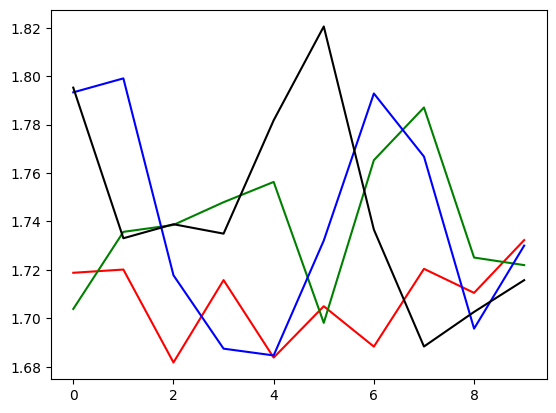

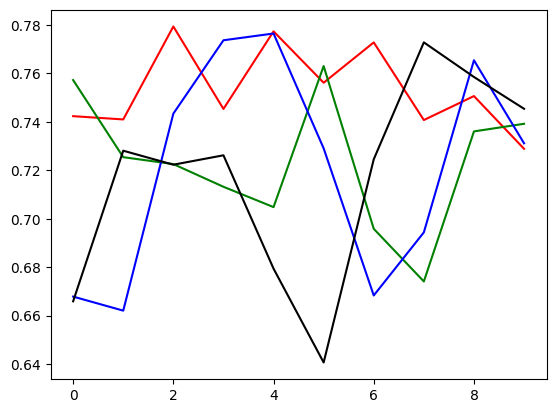

In [211]:
def plt_his(hiss):
    for i,his in enumerate(hiss):
        color = ['r','g', 'b', 'k']
        plt.plot(his.epoch,his.history['loss'],color[i])
    plt.show()
    for i,his in enumerate(hiss):
        color = ['r','g', 'b', 'k']
        plt.plot(his.epoch,his.history['accuracy'],color[i])
    plt.show()

plt_his([his_Xi,his_he,his_hae,his_hae2])
# his_Xi.history

In [188]:
model_hae.get_layer(index=1).get_weights()
# model_he.get_layer(index=1).get_weights()

[array([[ 0.00677703, -0.02404725,  0.01263944, ...,  0.00932128,
         -0.01206573,  0.02729032],
        [-0.00088009,  0.0121225 ,  0.02249593, ...,  0.00230605,
          0.07732417,  0.06219489],
        [ 0.00235428,  0.07636271, -0.04450391, ..., -0.18452962,
          0.03342156,  0.11902061],
        ...,
        [ 0.01184993,  0.0028269 ,  0.0281931 , ...,  0.04077711,
         -0.1192015 ,  0.10879866],
        [ 0.05631174, -0.10465871,  0.02488128, ...,  0.02694995,
         -0.08375163,  0.20857261],
        [-0.05131996, -0.00916926,  0.00227103, ...,  0.01264872,
          0.08754641,  0.00080393]], dtype=float32),
 array([ 2.00723171e-01, -1.52483620e-02, -2.76947021e-02,  6.78422526e-02,
         4.86009382e-02, -6.98072687e-02, -2.44909599e-01,  5.71955740e-01,
        -1.57343462e-01,  1.05040215e-01,  5.50034702e-01, -1.61200333e-02,
         2.02727526e-01,  1.49821434e-02,  5.30785508e-02,  3.07504267e-01,
        -4.77089547e-03, -8.23394433e-02, -5.56655861e

In [196]:
his_hae.history.keys()

dict_keys(['loss', 'accuracy'])

In [212]:
test_loss, test_acc = model_xavier.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
test_loss, test_acc = model_he.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
test_loss, test_acc = model_hae.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 1.7376 - accuracy: 0.7236

Test accuracy: 0.7235999703407288
313/313 - 0s - loss: 1.7697 - accuracy: 0.6915

Test accuracy: 0.6915000081062317
313/313 - 0s - loss: 1.6808 - accuracy: 0.7803

Test accuracy: 0.7803000211715698


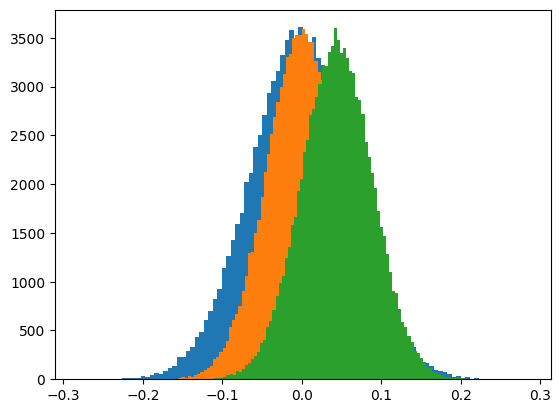

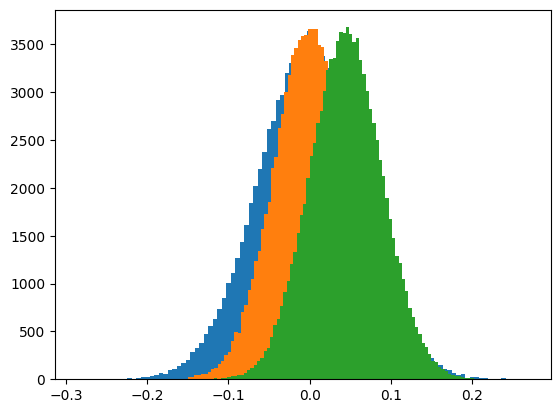

In [95]:
plt.hist(tf.random.normal([100000],stddev=1/np.sqrt(500/2)).numpy(),100)
plt.hist(tf.random.normal([100000],stddev=1/np.sqrt(500)).numpy(),100)
plt.hist(tf.random.normal([100000],mean=1/np.sqrt(500) ,stddev=1/np.sqrt(500)).numpy(),100)
plt.show()
plt.hist(np.random.randn(100000)/np.sqrt(500/2),100)
plt.hist(np.random.randn(100000)/np.sqrt(500),100)
plt.hist(np.random.randn(100000)/np.sqrt(500)+1/np.sqrt(500),100)
plt.show()
# plt.show()
# plt.show()